In [68]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score

In [82]:
original_data = pd.read_csv("answerList_data.csv")

def calculate_ttr(answer):
  if isinstance(answer, str):
    unique_words = set(answer.split(' '))
    word_count = len(answer.split(' '))
    return len(unique_words) / word_count
  return 0

def calculate_answer_len(answer):
  if isinstance(answer, str):
    return len(answer.split(' '))
  return 0

original_data['TTR'] = original_data['Answer.explanation'].apply(calculate_ttr)
original_data['Answer.size'] = original_data['Answer.explanation'].apply(calculate_answer_len)

holdout_methods = ['HIT01_8', 'HIT02_24']
holdout = original_data[original_data['FailingMethod'].isin(holdout_methods)]
training = original_data[~original_data['FailingMethod'].isin(holdout_methods)]


X = training[['Worker.score', 'Worker.profession', 'Answer.confidence', 'Answer.difficulty', 'TTR', 'Answer.size']]
y = training['GroundTruth']

X = pd.get_dummies(X)

clf = RandomForestClassifier(n_estimators= 77)

clf.fit(X, y)

precision_scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')

print(f"Cross-validated Precision: {precision_scores}")
print(f"Cross-validated Recall: {recall_scores}")

# Categorize Answers: Use your classifier (on the holdout set!) to label each answer (row).

X_holdout = holdout[['Worker.score', 'Worker.profession', 'Answer.confidence', 'Answer.difficulty', 'TTR', 'Answer.size']]
y_holdout = holdout[['GroundTruth']]

X_holdout = pd.get_dummies(X_holdout)

X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

print(f"Accuracy score: ", clf.score(X_holdout, y_holdout))

predicted_target = clf.predict(X_holdout)

X_holdout['predicted_target'] = np.array(predicted_target)

print("-----")
for method, failingmethod_data in holdout.groupby('FailingMethod'):
    X_failingMethod = pd.get_dummies(failingmethod_data[['Worker.score', 'Worker.profession', 'Answer.confidence', 'Answer.difficulty', 'TTR', 'Answer.size']])
    X_failingMethod = X_failingMethod.reindex(columns=X.columns, fill_value=0)

    precision = precision_score(failingmethod_data['GroundTruth'], clf.predict(X_failingMethod))
    recall = recall_score(failingmethod_data['GroundTruth'], clf.predict(X_failingMethod))
    print(f"FailingMethod: {method}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("-----")

precision = precision_score(holdout['GroundTruth'], predicted_target)
recall = recall_score(holdout['GroundTruth'], predicted_target)

print('Length of holdout set: ', len(holdout))
print(f"Holdout Precision: {precision:.2f}")
print(f"Holdout Recall: {recall:.2f}")

Cross-validated Precision: [0.2962963  0.125      0.2        0.34482759 0.26923077]
Cross-validated Recall: [0.0952381  0.0952381  0.07142857 0.0952381  0.08333333]
Accuracy score:  0.73125
-----
FailingMethod: HIT01_8
Precision: 0.18
Recall: 0.05
-----
FailingMethod: HIT02_24
Precision: 0.60
Recall: 0.07
-----
Length of holdout set:  320
Holdout Precision: 0.31
Holdout Recall: 0.06


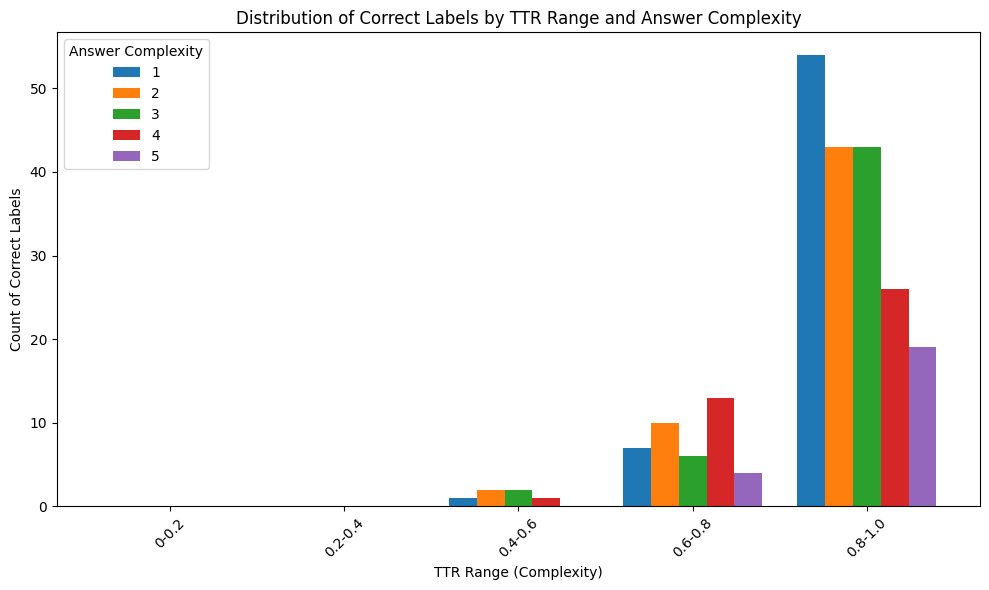

In [ ]:
correctly_predicted = holdout[X_holdout['predicted_target'] == holdout['GroundTruth']]

import matplotlib.pyplot as plt

bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1.0']

correctly_predicted = correctly_predicted.copy()
correctly_predicted.loc[:, 'TTR_range'] = pd.cut(correctly_predicted['TTR'], bins=bins, labels=labels, include_lowest=True)

distribution = correctly_predicted.groupby(['TTR_range', 'Answer.difficulty'], observed=False).size().reset_index(name='Count')

pivot_table = distribution.pivot(index='TTR_range', columns='Answer.difficulty', values='Count').fillna(0)

pivot_table.plot(kind='bar', figsize=(10, 6), width=0.8)

plt.xlabel('TTR Range (Complexity)')
plt.ylabel('Count of Correct Labels')
plt.title('Distribution of Correct Labels by TTR Range and Answer Complexity')
plt.xticks(rotation=45)
plt.legend(title='Answer Complexity')
plt.tight_layout()

plt.show()

#############################################################################



In [ ]:
# Specification 2

# for the correct answers to the inspection tasks hosting the bug, prompt the LLM
# to generate a single explanation by merging the participants’ explanations in a way that minimizes
#redundant information, while keeping the information that would be necessary for someone else to fix the
#bug.
#• Types of information that, if present in the explanation, should be preserved - how the program works,
#how the failure is happening, what is problem in the code, etc.
#• Try different ways of prompting and report on how the size and complexity of explanations changed.

correct_answers = original_data[original_data["GroundTruth"] == 1]

correct_answer_explanations = correct_answers[['FailingMethod', 'Answer.explanation']]

correct_answer_explanations.to_csv('answer_explanations.csv')

correct_answer_explanations.head()

,FailingMethod,Answer.explanation
20,HIT01_8,Minutes are set to -15; which is less then 0 a...
21,HIT01_8,The code never gets that far. The problem is a...
22,HIT01_8,In the code there is a check that 0 <= minutes...
23,HIT01_8,There is a logical check for if minuteOffset i...
24,HIT01_8,YES. The issue is on line 279 (as I explained ...


In [81]:
# Initial LLM prompting
llm_generated_summary = pd.read_csv('initial_llm_Fully_Refined_Bug_Fix_Explanations.csv')



llm_generated_summary['TTR'] = llm_generated_summary['Cleaned Explanation'].apply(calculate_ttr)
llm_generated_summary['Answer.size'] = llm_generated_summary['Cleaned Explanation'].apply(calculate_answer_len)

llm_generated_summary

,FailingMethod,Cleaned Explanation,TTR,Answer.size
0,HIT01_8,the variable should be defined as 'unsigned in...,0.374593,614
1,HIT02_24,"g is an integer, which is acceptable when crea...",0.375224,557
2,HIT03_6,"This is definitely where the problem is, but I...",0.360515,1165
3,HIT04_7,There would be an issue cause the function add...,0.350877,1254
4,HIT05_35,I do not know enough about arrays in JAVA to k...,0.365721,916
5,HIT06_51,The comparison between (long)x == x could caus...,0.397756,802
6,HIT07_33,I do not believe there is any issue with how a...,0.346756,894
7,HIT08_54,both the variable ch3 and ch4 defined correctl...,0.389503,724


In [79]:
# LLM crafted prompting
llm_prompted_generated_summary = pd.read_csv('llm_refined_bug_report_explanations_full.csv')

llm_prompted_generated_summary['TTR'] = llm_prompted_generated_summary['Refined Explanation'].apply(calculate_ttr)
llm_prompted_generated_summary['Answer.size'] = llm_prompted_generated_summary['Refined Explanation'].apply(calculate_answer_len)

llm_prompted_generated_summary


,Failing Method,Refined Explanation,TTR,Answer.size
0,HIT01_8,"Minutes are set to -15, which is less then 0 a...",0.335931,1155
1,HIT02_24,It's not clear if the program was meant to acc...,0.376749,929
2,HIT03_6,There is no reference to the variable 'pos' in...,0.320336,2026
3,HIT04_7,The tested code only adds one TimePeriod to th...,0.314664,2339
4,HIT05_35,If array is null and element is null it sets t...,0.318946,1784
5,HIT06_51,All of the conditionals appear to be functioni...,0.337104,1768
6,HIT07_33,"it looks fine to me. It checks for NULL first,...",0.310073,1648
7,HIT08_54,Not per se as the length is fine according to ...,0.298420,1709


In [80]:
# Roleplay LLM crafted prompting
roleplay_llm_prompted_generated_summary = pd.read_csv('roleplay_Refined_Bug_Report_Summaries.csv')

roleplay_llm_prompted_generated_summary['TTR'] = roleplay_llm_prompted_generated_summary['Refined Explanation'].apply(calculate_ttr)
roleplay_llm_prompted_generated_summary['Answer.size'] = roleplay_llm_prompted_generated_summary['Refined Explanation'].apply(calculate_answer_len)

roleplay_llm_prompted_generated_summary

,FailingMethod,Refined Explanation,TTR,Answer.size
0,HIT01_8,Minutes are set to -15; which is less then 0 a...,0.341530,1098
1,HIT02_24,It's not clear if the program was meant to acc...,0.406607,787
2,HIT03_6,There is no reference to the variable 'pos' in...,0.326636,1941
3,HIT04_7,The tested code only adds one TimePeriod to th...,0.306500,2323
4,HIT05_35,If array is null and element is null it sets t...,0.325458,1693
5,HIT06_51,All of the conditionals appear to be functioni...,0.342700,1637
6,HIT07_33,It checks for NULL first; if it's not null the...,0.320565,1488
7,HIT08_54,The country code is missing. Or rather lines 1...,0.300371,1618


In [43]:
from evaluate import load
from nltk.translate.bleu_score import sentence_bleu

#Pre-processing the original file.

initial_data = pd.read_csv('answerList_data.csv')

initial_data['Answer.explanation'] = initial_data['Answer.explanation'].astype(str)


initial_data = initial_data.groupby("FailingMethod", as_index=False).agg({"Answer.explanation": lambda x: " ".join(x)})


data_rows = []



for index in range(len(initial_data)):
  rouge = load("rouge")

  prediction_model_output = [llm_generated_summary['Cleaned Explanation'][index]]
  reference_groundtruth= [[initial_data['Answer.explanation'][index]]]

  results = rouge.compute(predictions=prediction_model_output, references=reference_groundtruth)

  prediction_sentence = llm_generated_summary['Cleaned Explanation'][index]
  reference_sentences = [initial_data['Answer.explanation'][index]]

  bleu_score = sentence_bleu(reference_sentences, prediction_sentence)
  data_rows.append({
      'FailingMethod': initial_data['FailingMethod'][index],
      'ROGUE1': results['rouge1'],
      'ROGUE2': results['rouge2'],
      'ROGUEL': results['rougeL'],
      'ROGUELsum': results['rougeLsum'],
      'BLEU': bleu_score
  })



score_table = pd.DataFrame(data_rows)



score_table.head()



,FailingMethod,ROGUE1,ROGUE2,ROGUEL,ROGUELsum,BLEU
0,HIT01_8,0.197467,0.188434,0.115622,0.115622,0.000187
1,HIT02_24,0.299141,0.283718,0.163802,0.163802,0.010667
2,HIT03_6,0.223827,0.213549,0.112195,0.112195,0.000646
3,HIT04_7,0.143587,0.135971,0.078544,0.078544,0.000005
4,HIT05_35,0.301356,0.287069,0.150678,0.150678,0.009524
